# Выпускной проект Черноуса Е.И. Мобильные приложения — Анализ поведения пользователей в мобильном приложении

# Задача:

1 Проанализируйте связь целевого события — просмотра контактов — и других действий пользователей.

2 Оцените, какие действия чаще совершают те пользователи, которые просматривают контакты.

Проведите исследовательский анализ данных

Проанализируйте влияние событий на совершение целевого события

Проверьте статистические гипотезы

1 Одни пользователи совершают действия tips_show и tips_click , другие — только tips_show . Проверьте гипотезу: конверсия в просмотры контактов различается у этих двух групп.

2 Сформулируйте собственную статистическую гипотезу. Дополните её нулевой и альтернативной гипотезами. Проверьте гипотезу с помощью статистического теста.

# Цели:

Управление вовлеченностью клиентов (адаптация приложения по целевой и смежной аудитории) будет актуально только на основе данных о поведении пользователей.

Получить на основе поведения пользователей гипотезы о том как можно было бы улучшить приложение с точки зрения пользовательского опыта.

# Описание данных:
Датасет содержит данные о событиях, совершенных в мобильном приложении
"Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в
приложении после 7 октября 2019 года.

Колонки в /datasets/mobile_sources.csv :

userId — идентификатор пользователя,

source — источник, с которого пользователь установил приложение.

Колонки в /datasets/mobile_dataset.csv :

event.time — время совершения,

user.id — идентификатор пользователя,

event.name — действие пользователя.

Виды действий:

advert_open — открыл карточки объявления,

photos_show — просмотрел фотографий в объявлении,

tips_show — увидел рекомендованные объявления,

tips_click — кликнул по рекомендованному объявлению,

contacts_show и show_contacts — посмотрел номер телефона,

contacts_call — позвонил по номеру из объявления,

map — открыл карту объявлений,

search_1 — search_7 — разные действия, связанные с поиском по сайту,

favorites_add — добавил объявление в избранное.

# Декомпозиция

1  Загрузка и первичный анализ данных

1.1  Загрузка данных

1.2  Проверка форматов данных, проверка на дубликаты

2  Подготовка данных

2.1  Избавление от дубликатов

2.2  Переименование столбцов (если нужно)

3  Иследовательский анализ

3.1  Выделение сессии в прложении по тайм-аутам

3.2  Определяем Retention Rate 

3.3  Поиск сценариев пользователя по сесии

3.4  Воронка дейсвий(конверсия в целевое действие)

В разрезе сессий отобрать сценарии\паттерны, которые приводят к просмотру контактов

Построить воронки по основным сценариям в разрезе уникальных пользователей

3.5  Рассчитать относительную частоту событий в разрезе двух групп пользователей:

группа пользователей, которые смотрели контакты contacts_show

группа пользователей, которые не смотрели контакты contacts_show

4  Гипотезы

4.1  Одни пользователи совершают действия tips_show и tips_click, другие – только tips_show. Проверить гипотезу, что конверсия в просмотр контактов различается у этих двух групп.

4.2  Проверим гипотезу о том что пользователи добавлявшие карточку в избранное имеют конверсию выше в просмотр контакта нежели те кто этого не делал

In [2]:
import pandas as pd
import plotly.io as pio
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2
from plotly import graph_objects as go
from tqdm import tqdm
import numpy as np
import plotly.express as px
import seaborn as sns
import math as mth
from scipy import stats as st
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

## Загрузка и первичный анализ данных

### Загрузка данных

In [3]:
dt_set = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
dt_sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_sources.csv')

In [4]:
dt_set.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [5]:
dt_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [6]:
dt_sources.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [7]:
dt_sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


В датасете 74 197 строк и 3 столбца,в базе данных о источниках 4293 строки и 2 стобца

### Проверка форматов данных, проверка на дубликаты

In [8]:
dt_sources.isna().sum()

userId    0
source    0
dtype: int64

In [9]:
dt_set.isna().sum()

event.time    0
event.name    0
user.id       0
dtype: int64

Пропусков в данных не обанружено

In [10]:
dt_set.duplicated().sum()

0

In [11]:
dt_sources.duplicated().sum()

0

Дубликатов в данных так же нет

Необходимо сменить формат данных в столбце event_time на datetime

In [12]:
dt_set['event.time'] = pd.to_datetime(dt_set['event.time'], format='%Y-%m-%d %H:%M:%S')

In [13]:
dt_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event.time  74197 non-null  datetime64[ns]
 1   event.name  74197 non-null  object        
 2   user.id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


In [14]:
dt_set.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


## Подготовка данных

Переименуем столбцы

In [15]:
dt_set.columns =['event_time', 'event_name', 'user_id']
dt_sources.columns =['user_id', 'source']

Объеденим обе таблицы

In [16]:
data = dt_set.merge(dt_sources, on='user_id', how='left')

In [17]:
data.head()

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   source      74197 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.8+ MB


In [19]:
data['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open      6164 
contacts_show    4450 
map              3881 
search_1         3506 
favorites_add    1417 
search_5         1049 
tips_click       814  
search_4         701  
contacts_call    541  
search_3         522  
search_6         460  
search_2         324  
search_7         222  
show_contacts    79   
Name: event_name, dtype: int64

объеденим похожие события такие как search_1,2,3,4,5,6,7 и contacts_show и show_contacts

In [20]:
def replace(name):
    if 'search_' in name:
        return 'search'
    elif 'show_' in name:
        return 'contacts_show'
    else: 
        return name

In [21]:
data['event_name']=data['event_name'].apply(replace)

In [22]:
data['event_name'].value_counts()

tips_show        40055
photos_show      10012
search           6784 
advert_open      6164 
contacts_show    4529 
map              3881 
favorites_add    1417 
tips_click       814  
contacts_call    541  
Name: event_name, dtype: int64

### Вывод

В данных не обаружено полных дубликатов и пропусков

Названия стобцов приведены к общему стилю

Два дата сета объеденины в один

Столбец с датой приведен к типу данных datetime

Одинаковые действия объединены 

## Иследовательский анализ

### Выделение сессии в прложении по тайм-аутам

In [23]:
data = data.sort_values(['user_id', 'event_time'])

In [24]:
data.head()

,event_time,event_name,user_id,source
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other


In [25]:
data['diff_time'] = (data.groupby('user_id')['event_time'].diff()
                     .dt.total_seconds().div(60) # преобразуем в минуты
                     .fillna(value=0) #заполним пропуски значением 0
                    )
data['diff_time'].describe(percentiles=[0.05, 1/4, 1/2, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.99])

count    74197.000000
mean     219.537112  
std      1488.939293 
min      0.000000    
5%       0.000000    
25%      0.272607    
50%      1.060508    
90%      14.028356   
91%      20.047997   
92%      33.771810   
93%      65.731040   
94%      152.147053  
95%      426.477334  
99%      6664.092718 
max      38269.914225
Name: diff_time, dtype: float64

50% пользователей имеют время между событиями в 1 минуту, 92% пользователей между событиями имеют 33 минуты из чего мы берем время тайм аута сессии в 30 минут, что будет включать 91 процент пользователй, после 33 минут время между событиями резко растет что может быть связано с выбросами.

In [26]:
g = (data.groupby('user_id')['event_time'].diff() > pd.Timedelta('30Min')).cumsum()
data['session_id'] = data.groupby(['user_id', g], sort=False).ngroup() + 1
data

,event_time,event_name,user_id,source,diff_time,session_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0.000000,1
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0.751059,1
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0.577826,1
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2.250216,1
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2.169701,1
...,...,...,...,...,...,...
72584,2019-11-03 15:51:23.959572,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,0.464775,10368
72589,2019-11-03 15:51:57.899997,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,0.565674,10368
72684,2019-11-03 16:07:40.932077,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,15.717201,10368
72688,2019-11-03 16:08:18.202734,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,0.621178,10368


Созданны сессии с временем тайм-аута 30 мин

### Определяем Retention Rate

Зададим функции для создания профиля, первой сесии и retention

In [27]:
def get_profiles(sessions):
 
    profiles = (
        data.sort_values(by=['user_id', 'event_time'])
        .groupby('user_id')
        .agg({'event_time': 'first', 'source': 'first'})
        .rename(columns={'event_time': 'first_ts'})
        .reset_index()  
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    return profiles

In [28]:
def get_session_start(sessions):
 
    sessions = (
        data.sort_values(by=['session_id', 'user_id'])
        .groupby(['session_id','user_id'])
        .agg({'event_time': 'first'})
        .rename(columns={'event_time': 'session_start'})
        .reset_index()
    )
    return sessions

In [29]:
def get_retention(
    profiles, sessions, observation_date, horizon_days, dimensions=[], ignore_horizon=False
):
    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    result_grouped = result_raw.pivot_table(
        index=dimensions, columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)
    
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    result_grouped['cohort_size'] = cohort_sizes

    return result_raw, result_grouped

In [30]:
profiles = get_profiles(data)

In [31]:
sessions = get_session_start(data)

In [32]:
observation_date = data['event_time'].max().date()
horizon_days = 14

ignore_horizon = False

In [33]:
retention_raw, retention = get_retention(
    profiles, sessions, observation_date, horizon_days, dimensions=['dt']
)
retention.head()

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
dt,,,,,,,,,,,,,,,
2019-10-07,204,1.0,0.117647,0.093137,0.107843,0.053922,0.034314,0.058824,0.078431,0.053922,0.049020,0.049020,0.034314,0.024510,0.058824
2019-10-08,167,1.0,0.161677,0.125749,0.053892,0.041916,0.065868,0.053892,0.071856,0.053892,0.035928,0.059880,0.023952,0.029940,0.029940
2019-10-09,176,1.0,0.073864,0.062500,0.056818,0.068182,0.068182,0.056818,0.073864,0.056818,0.034091,0.022727,0.028409,0.034091,0.056818
2019-10-10,174,1.0,0.086207,0.103448,0.080460,0.091954,0.080460,0.068966,0.051724,0.080460,0.034483,0.034483,0.051724,0.045977,0.040230
2019-10-11,136,1.0,0.088235,0.117647,0.095588,0.088235,0.073529,0.066176,0.044118,0.014706,0.044118,0.036765,0.036765,0.051471,0.029412


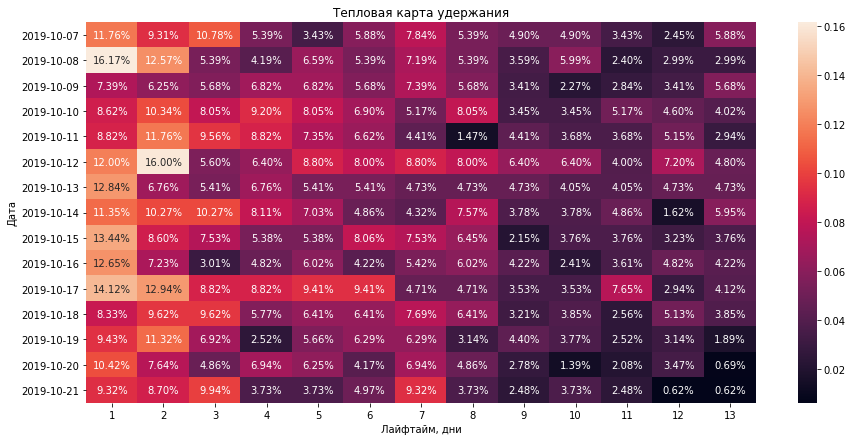

In [34]:
fig = plt.figure(figsize = (15, 7))
sns.heatmap(retention.drop(columns = ['cohort_size',0]),
            annot = True, 
            fmt = '.2%' 
           )
plt.title('Тепловая карта удержания')
plt.xlabel('Лайфтайм, дни')
plt.ylabel('Дата')
plt.show()

Лучшее удержание пользователей было у пришедших в приложение с 07-14 число, далее удержание на 14 дней только снижалось

### Поиск сценариев пользователя по сесии

Найдем сколько у нас дубликатов событий в рамках сессий

In [35]:
data.duplicated(subset=['session_id', 'event_name']).sum()

56343

In [36]:
skript = data.drop_duplicates(subset=['session_id', 'event_name'])
skript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17854 entries, 805 to 72552
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  17854 non-null  datetime64[ns]
 1   event_name  17854 non-null  object        
 2   user_id     17854 non-null  object        
 3   source      17854 non-null  object        
 4   diff_time   17854 non-null  float64       
 5   session_id  17854 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 976.4+ KB


In [37]:
#Преобразование исходной таблицы
def add_features(df):
    
    """Функция генерации новых столбцов для исходной таблицы

    Args:
        df (pd.DataFrame): исходная таблица.
    Returns:
        pd.DataFrame: таблица с новыми признаками.
    """
    
    # сортируем по id и времени
    sorted_df = df.sort_values(by=['session_id', 'event_time']).copy()
     # добавляем шаги событий
    sorted_df['step'] = sorted_df.groupby('session_id').cumcount() + 1
    
    # добавляем узлы-источники и целевые узлы
    # узлы-источники - это сами события
    sorted_df['source'] = sorted_df['event_name']
    # добавляем целевые узлы
    sorted_df['target'] = sorted_df.groupby('session_id')['source'].shift(-1) 
    
    # возврат таблицы без имени событий
    return sorted_df.drop(['event_name'], axis=1)
# преобразуем таблицу
table = add_features(skript)
table.head()

,event_time,user_id,source,diff_time,session_id,step,target
805,2019-10-07 13:39:45.989359,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,0.000000,1,1,NaN
6541,2019-10-09 18:33:55.577963,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,map,3164.231022,2,1,tips_show
6565,2019-10-09 18:40:28.738785,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,5.007964,2,2,NaN
36412,2019-10-21 19:52:30.778932,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,17350.130250,3,1,map
36419,2019-10-21 19:53:38.767230,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,map,0.360037,3,2,NaN


In [38]:
table['step'].describe()

count    17854.000000
mean     1.592752    
std      0.822576    
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      2.000000    
max      6.000000    
Name: step, dtype: float64

Максимальное кол-во шагов 6, 75% выполняют лишь два шага.
Возьмем 4 шага как чтото среднее что бы получить большее кол-во результатов

In [39]:
# удалим все пары source-target, шаг которых превышает 4
# и сохраним полученную таблицу в отдельную переменную
df_comp = table[table['step'] <= 4].copy().reset_index(drop=True)

In [40]:
def get_source_index(df):
    
    """Функция генерации индексов source

    Args:
        df (pd.DataFrame): исходная таблица с признаками step, source, target.
    Returns:
        dict: словарь с индексами, именами и соответсвиями индексов именам source.
    """
    
    res_dict = {}
    
    count = 0
    # получаем индексы источников
    for no, step in enumerate(df['step'].unique().tolist()):
        # получаем уникальные наименования для шага
        res_dict[no+1] = {}
        res_dict[no+1]['sources'] = df[df['step'] == step]['source'].unique().tolist()
        res_dict[no+1]['sources_index'] = []
        for i in range(len(res_dict[no+1]['sources'])):
            res_dict[no+1]['sources_index'].append(count)
            count += 1
            
    # соединим списки
    for key in res_dict:
        res_dict[key]['sources_dict'] = {}
        for name, no in zip(res_dict[key]['sources'], res_dict[key]['sources_index']):
            res_dict[key]['sources_dict'][name] = no
    return res_dict
  

# создаем словарь
source_indexes = get_source_index(df_comp)

In [41]:
#Функция случайной генерации цветов
def colors_for_sources():
    
    """Генерация цветов rgba

    Returns:
        dict: словарь с цветами, сгенерированными рандомно и соответствующими каждому индексу
    """
    # словарь, в который сложим цвета в соответствии с индексом
    colors_dict = {}
    
  # генерим случайные цвета
    for label in df_comp['source'].unique():
        r, g, b = np.random.randint(255, size=3)            
        colors_dict[label] = f'rgba({r}, {g}, {b}, 1)'
            
    return colors_dict

#гененируем цвета
colors_dict = colors_for_sources()

In [42]:
def percent_users(sources, targets, values):
    
    """
    Расчет уникальных id в процентах (для вывода в hover text каждого узла)
    
    Args:
        sources (list): список с индексами source.
        targets (list): список с индексами target.
        values (list): список с "объемами" потоков.
        
    Returns:
        list: список с "объемами" потоков в процентах
    """
    
    # объединим источники и метки и найдем пары
    zip_lists = list(zip(sources, targets, values))
    
    new_list = []
    
    # подготовим список словарь с общим объемом трафика в узлах
    unique_dict = {}
    
    # проходим по каждому узлу
    for source, target, value in zip_lists:
        if source not in unique_dict:
            # находим все источники и считаем общий трафик
            unique_dict[source] = 0
            for sr, tg, vl in zip_lists:
                if sr == source:
                    unique_dict[source] += vl
                    
    # считаем проценты
    for source, target, value in zip_lists:
        new_list.append(round(100 * value / unique_dict[source], 1))
    
    return new_list

In [43]:
#Создание словаря с данными для отрисовки диаграммы
def lists_for_plot(source_indexes=source_indexes, colors=colors_dict, frac=10):
    
    """
    Создаем необходимые для отрисовки диаграммы переменные списков и возвращаем
    их в виде словаря
    
    Args:
        source_indexes (dict): словарь с именами и индексами source.
        colors (dict): словарь с цветами source.
        frac (int): ограничение на минимальный "объем" между узлами.
        
    Returns:
        dict: словарь со списками, необходимыми для диаграммы.
    """
    
    sources = []
    targets = []
    values = []
    labels = []
    link_color = []
    link_text = []

    # проходим по каждому шагу
    for step in tqdm(sorted(df_comp['step'].unique()), desc='Шаг'):
        if step + 1 not in source_indexes:
            continue

        # получаем индекс источника
        temp_dict_source = source_indexes[step]['sources_dict']

        # получаем индексы цели
        temp_dict_target = source_indexes[step+1]['sources_dict']

        # проходим по каждой возможной паре, считаем количество таких пар
        for source, index_source in tqdm(temp_dict_source.items()):
            for target, index_target in temp_dict_target.items():
                # делаем срез данных и считаем количество id            
                temp_df = df_comp[(df_comp['step'] == step)&(df_comp['source'] == source)&(df_comp['target'] == target)]
                value = len(temp_df)
                # проверяем минимальный объем потока и добавляем нужные данные
                if value > frac:
                    sources.append(index_source)
                    targets.append(index_target)
                    values.append(value)
                    # делаем поток прозрачным для лучшего отображения
                    link_color.append(colors[source].replace(', 1)', ', 0.2)'))
                    
    labels = []
    colors_labels = []
    for key in source_indexes:
        for name in source_indexes[key]['sources']:
            labels.append(name)
            colors_labels.append(colors[name])
            
    # посчитаем проценты всех потоков
    perc_values = percent_users(sources, targets, values)
    
    # добавим значения процентов для howertext
    link_text = []
    for perc in perc_values:
        link_text.append(f"{perc}%")
    
    # возвратим словарь с вложенными списками
    return {'sources': sources, 
            'targets': targets, 
            'values': values, 
            'labels': labels, 
            'colors_labels': colors_labels, 
            'link_color': link_color, 
            'link_text': link_text}
  

# создаем словарь
data_for_plot = lists_for_plot()

Шаг: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s]


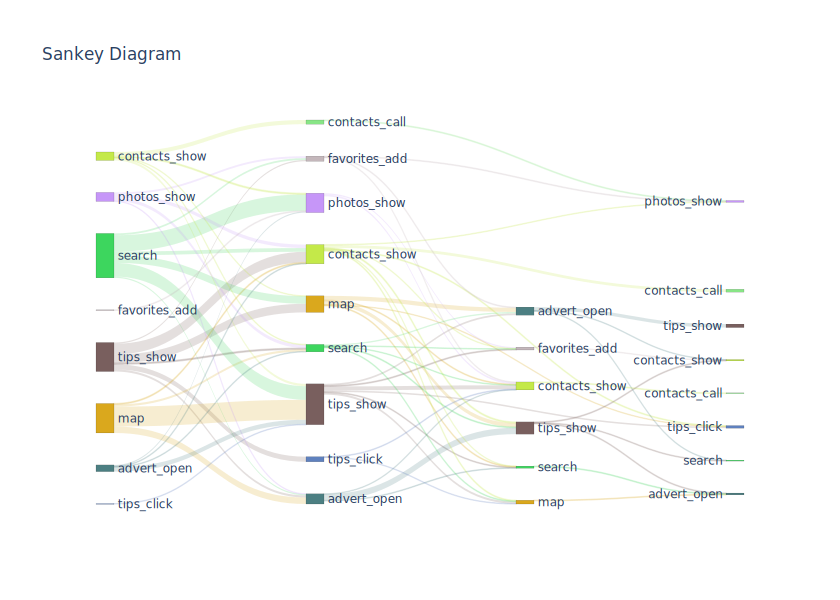

In [44]:
def plot_senkey_diagram(data_dict=data_for_plot):    
    
    """
    Функция для генерации объекта диаграммы Сенкей 
    
    Args:
        data_dict (dict): словарь со списками данных для построения.
        
    Returns:
        plotly.graph_objs._figure.Figure: объект изображения.
    """
    
    fig = go.Figure(data=[go.Sankey(
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
          pad = 50,
          thickness = 15,
          line = dict(color = "black", width = 0.1),
          label = data_dict['labels'],
          color = data_dict['colors_labels']
        ),
        link = dict(
          source = data_dict['sources'],
          target = data_dict['targets'],
          value = data_dict['values'],
          label = data_dict['link_text'],
          color = data_dict['link_color']
      ))])
    fig.update_layout(title_text="Sankey Diagram", font_size=10)
    
    # возвращаем объект диаграммы
    return fig
  

# сохраняем диаграмму в переменную
senkey_diagram = plot_senkey_diagram()
senkey_diagram.show()

По диаграмме видно что некоторые сценарии пользователя начинаюся сразу с contacts_show, что может быть из-за перехода по прямой ссылке.

Наиболее популярными сценариями пользователя для дальнейшего изучения являются:

map-tips_show-contacts_show

search-photos_show-contacts_show

tips_show-map-contacts_show

### Воронка дейсвий(конверсия в целевое действие)

Воронка действий 

map-tips_show-contacts_show

In [45]:
funnel_map = ['map', 'tips_show', 'contacts_show']

In [46]:
#step_1 = df_comp.query('source == "map"')['user_id'].unique()
#step_2 = df_comp.query('user_id in @step_1 and source == "tips_show"')['user_id'].unique()
#step_3 = df_comp.query('user_id in @step_2 and source == "contacts_show"')['user_id'].unique()

#map_list = [len(step_1), len(step_2), len(step_3)]

In [47]:
step_1 = data.query('event_name == "map"')['user_id'].unique()
step_2 = data.query('user_id in @step_1 and event_name == "tips_show"')['user_id'].unique()
step_3 = data.query('user_id in @step_2 and event_name == "contacts_show"')['user_id'].unique()

map_list = [len(step_1), len(step_2), len(step_3)]

In [48]:
# КОД РЕВЬЮЕРА

data.query("event_name == 'map'")['user_id'].nunique()

1456

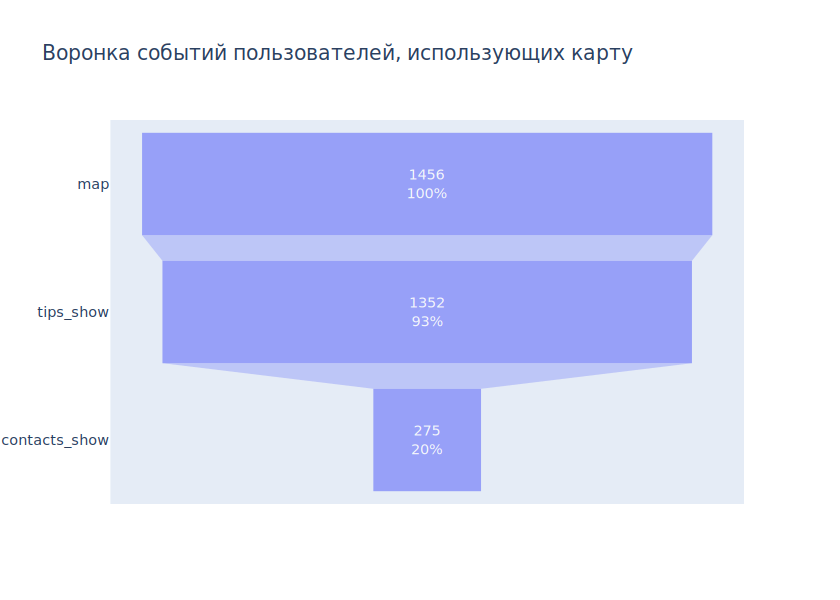

In [49]:
fig = go.Figure(go.Funnel(y = funnel_map,
                          x = map_list,
                          opacity = 0.6,
                          textposition = 'inside',
                          textinfo = 'value + percent previous'))
fig.update_layout(title='Воронка событий пользователей, использующих карту')

В данном сценарии пользователи с шага карта 1456 человек на следующий шаг tips_show переходит  93% из них и до целевого действия показать контакт доходит лишь 275 человек что составляет 20,3% что является не самой низкой конверсией

Воронка действий

search-photos_show-contacts_show

In [50]:
funnel_search = ['search', 'photos_show', 'contacts_show']

In [51]:
data.query("event_name == 'search'")['user_id'].nunique()

1666

In [53]:
step_1 = data.query('event_name == "search"')['user_id'].unique()
step_2 = data.query('user_id in @step_1 and event_name == "photos_show"')['user_id'].unique()
step_3 = data.query('user_id in @step_2 and event_name == "contacts_show"')['user_id'].unique()

search_list = [len(step_1), len(step_2), len(step_3)]

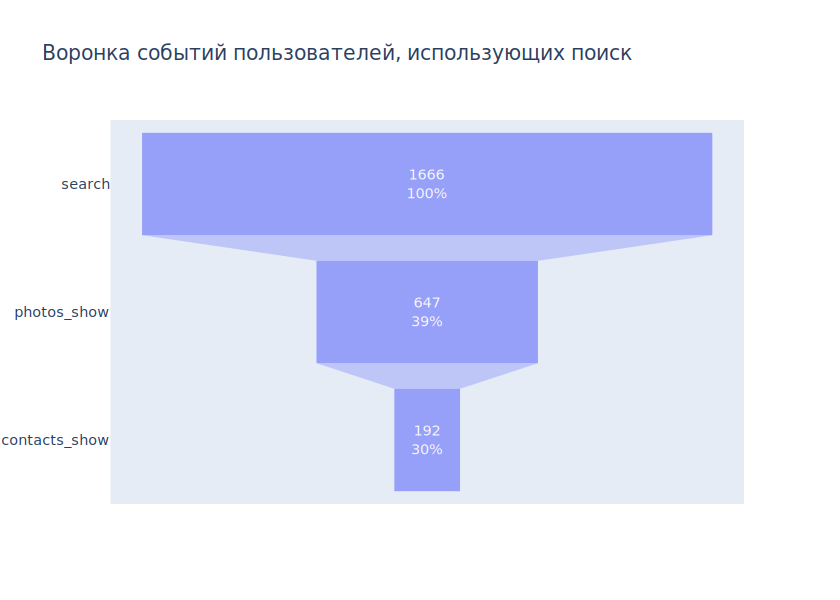

In [54]:
fig = go.Figure(go.Funnel(y = funnel_search,
                          x = search_list,
                          opacity = 0.6,
                          textposition = 'inside',
                          textinfo = 'value + percent previous'))
fig.update_layout(title='Воронка событий пользователей, использующих поиск')

В данном сценарии пользователи начинают с шага поиск 1666 человек на следующий шаг photos_show переходит лишь 39% из них и до целевого действия показать контакт доходит лишь 192 человека что составляет 30% что является хорошей конверсией для сценария

Воронка действий

tips_show-map-contacts_show

In [55]:
funnel_tips = ['tips_show', 'map', 'contacts_show']

In [56]:
data.query("event_name == 'tips_show'")['user_id'].nunique()

2801

In [58]:
step_1 = data.query('event_name == "tips_show"')['user_id'].unique()
step_2 = data.query('user_id in @step_1 and event_name == "map"')['user_id'].unique()
step_3 = data.query('user_id in @step_2 and event_name == "contacts_show"')['user_id'].unique()

tips_list = [len(step_1), len(step_2), len(step_3)]

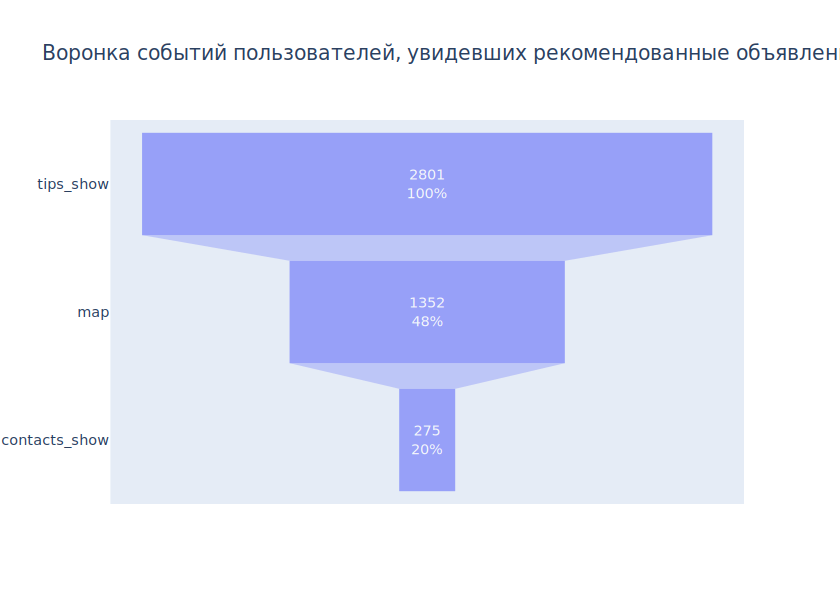

In [59]:
fig = go.Figure(go.Funnel(y = funnel_tips,
                          x = tips_list,
                          opacity = 0.6,
                          textposition = 'inside',
                          textinfo = 'value + percent previous'))
fig.update_layout(title='Воронка событий пользователей, увидевших рекомендованные объявления')

В данном сценарии пользователи начинают с шага увидел рекомендованное объявление 2801 человек на следующий шаг map переходит лишь 48% из них и до целевого действия показать контакт доходит лишь 275 человека что составляет 20%  что является не самой низкой конверсией

Сценарий пользователя search-photos_show-contacts_show оказался самым конверсионным для достижения целевого действия целых 30%

Конверсию хуже показали два других сценария на уровне 20% что может быть связано с тем что рекомендованное  объявление предлагает слишком удаленные от пользователя местоположения и из-за этого пользователь не переходит к звонку

### Рассчитать относительную частоту событий в разрезе двух групп пользователей

группа пользователей, которые смотрели контакты contacts_show

группа пользователей, которые не смотрели контакты contacts_show


In [60]:
contacts_show_users = data.query('event_name=="contacts_show"')['user_id'].unique().tolist()
print("Пользователи совершавшие contacts_show =", len(contacts_show_users))

all_users = data['user_id'].unique()
print("Кол-во всех пользователей =", len(all_users))

no_contacts_show_users = list( set(all_users) - set(contacts_show_users) )
print("Пользователи не совершавшие contacts_show =", len(no_contacts_show_users))

Пользователи совершавшие contacts_show = 981
Кол-во всех пользователей = 4293
Пользователи не совершавшие contacts_show = 3312


In [61]:
no_contacts_show_users1 = data.query('user_id==@no_contacts_show_users')
no_contacts_show_users1

,event_time,event_name,user_id,source,diff_time,session_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0.000000,1
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0.751059,1
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0.577826,1
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2.250216,1
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2.169701,1
...,...,...,...,...,...,...
50931,2019-10-26 19:42:23.075149,tips_show,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,yandex,1.857678,10333
50955,2019-10-26 19:48:44.332260,tips_show,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,yandex,6.354285,10333
50982,2019-10-26 19:53:51.993545,tips_show,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,yandex,5.127688,10333
40406,2019-10-23 11:51:35.199237,tips_show,ffcf50d9-293c-4254-8243-4890b030b238,google,0.000000,10335


In [62]:
converse = no_contacts_show_users1['event_name'].value_counts().reset_index()
converse.columns = ['event', 'all']
converse_sum = converse['all'].sum()
converse['per'] = 100*(converse['all']/converse_sum)
converse

,event,all,per
0,tips_show,27287,58.057447
1,photos_show,6184,13.157447
2,search,4700,10.000000
3,advert_open,4575,9.734043
4,map,2780,5.914894
5,favorites_add,993,2.112766
6,tips_click,481,1.023404


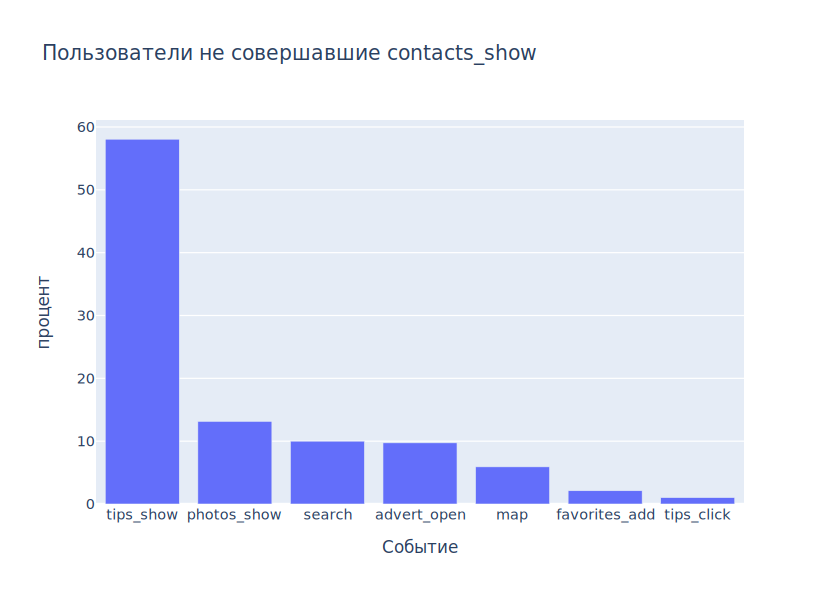

In [63]:
fig = px.bar(converse, x='event', y='per',
             title="Пользователи не совершавшие contacts_show",labels = {'per': 'процент', 'event': 'Событие'})

fig.show()

In [64]:
contacts_show = data.query('user_id==@contacts_show_users')
contacts_show

,event_time,event_name,user_id,source,diff_time,session_id
31632,2019-10-19 21:34:33.849769,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,0.000000,5
31636,2019-10-19 21:35:19.296599,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,0.757447,5
31640,2019-10-19 21:36:44.344691,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,1.417468,5
31655,2019-10-19 21:40:38.990477,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,3.910763,5
31659,2019-10-19 21:42:13.837523,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,1.580784,5
...,...,...,...,...,...,...
72584,2019-11-03 15:51:23.959572,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,0.464775,10368
72589,2019-11-03 15:51:57.899997,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,0.565674,10368
72684,2019-11-03 16:07:40.932077,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,15.717201,10368
72688,2019-11-03 16:08:18.202734,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,0.621178,10368


In [65]:
converse1 = contacts_show['event_name'].value_counts().reset_index()
converse1 = converse1.drop (index=[ 1 , 6])
converse1.columns = ['event', 'all']
converse1_sum = converse1['all'].sum()
converse1['per'] = 100*(converse1['all']/converse1_sum)
converse1

,event,all,per
0,tips_show,12768,57.703258
2,photos_show,3828,17.300131
3,search,2084,9.418358
4,advert_open,1589,7.181272
5,map,1101,4.975821
7,favorites_add,424,1.916211
8,tips_click,333,1.504949


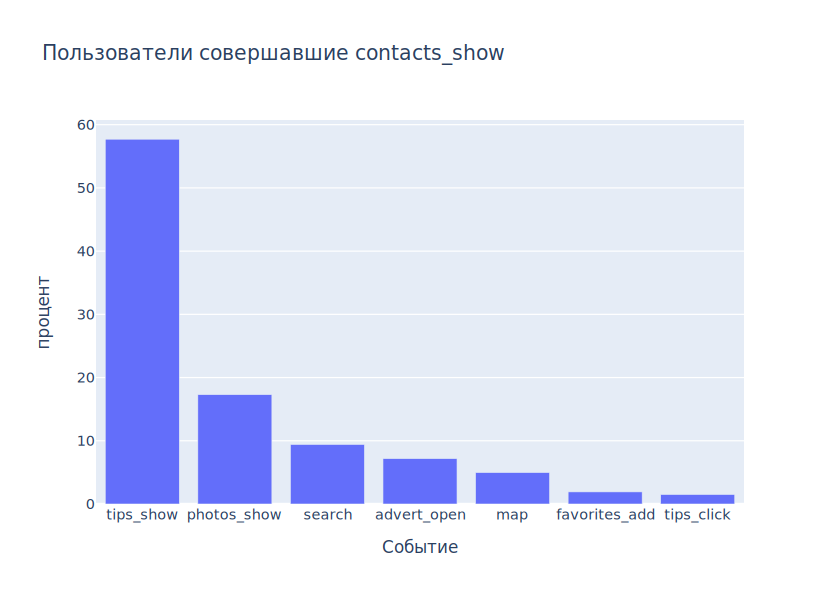

In [66]:
fig = px.bar(converse1, x='event', y='per',
             title="Пользователи совершавшие contacts_show",labels = {'per': 'процент', 'event': 'Событие'})

fig.show()

Группа пользователей совершвашие целевое действие имеют частоту photos_show выше 16.9% против 13.2%

Но открытие карточки ниже 7% против 9.73%, так же ниже откртие карты 4.86.5 против 5.91%

## Гипотезы



### Одни пользователи совершают действия tips_show и tips_click, другие – только tips_show. Проверить гипотезу, что конверсия в просмотр контактов различается у этих двух групп

H0: конверсия в просмотры контактов не различается у групп по действиям tips_show + tips_click и tips_show

H1: конверсия в просмотры отличается

In [67]:
tips_show_all = data.query('event_name =="tips_show"')['user_id'].unique().tolist()
print('Количество пользователей, совершивших действие tips_show:', len(tips_show_all))

Количество пользователей, совершивших действие tips_show: 2801


In [68]:
tips_show_click = data.query('event_name =="tips_click" and user_id==@tips_show_all')['user_id'].unique().tolist()
print('Количество пользователей, совершивших действия tips_show + tips_click:', len(tips_show_click))

Количество пользователей, совершивших действия tips_show + tips_click: 297


In [69]:
tips_show = list(set(tips_show_all) - set(tips_show_click))
print('Количество пользователей, совершивших только действие tips_show:', len(tips_show))

Количество пользователей, совершивших только действие tips_show: 2504


Уровень статистической значимости установим на уровне alpha = 0.05.

In [70]:
target_tips_show = data.query('user_id in @tips_show and event_name == "contacts_show"')['user_id'].unique()
print('Количество пользователей, совершивших только действие tips_show и просмотревших контакты:', len(target_tips_show))

Количество пользователей, совершивших только действие tips_show и просмотревших контакты: 425


In [71]:
target_tips_show_click = data.query('user_id in @tips_show_click and event_name == "contacts_show"')['user_id'].unique()
print('Количество пользователей, совершивших действия tips_show + tips_click и просмотревших контакты:',
      len(target_tips_show_click))

Количество пользователей, совершивших действия tips_show + tips_click и просмотревших контакты: 91


In [72]:
alpha = 0.05  # критический уровень статистической значимости

successes = np.array([len(target_tips_show),len(target_tips_show_click)])
trials = np.array([len(tips_show),len(tips_show_click)])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)
print('Конверсии:',p1, 'и', p2)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-value:  9.218316554537864e-09
Конверсии: 0.16972843450479233 и 0.3063973063973064
Отвергаем нулевую гипотезу: между долями есть значимая разница


Результат теста показывает, что разница между долями значима, то есть вероятность просмотра контактов среди пользователей, которые совершили события tips_show и tips_click, выше, чем среди тех, кто совершил только tips_show. Конверсия для первой группы (выполнен только tips_show) равна 16,9%, в то время как для второй группы (выполнены оба события - tips_show и tips_click) она значительно выше - 30,6%.

###  Проверим гипотезу о том что пользователи добавлявшие карточку в избранное имеют конверсию выше в просмотр контакта чем те кто открывали карту

H0: Конверсия в целевое событие между группами кто добавлял объявление в избраное и те кто открывал карту одинаковая

H1: Конверсия у этих двух групп различается

In [73]:
favorites_add = data.query('event_name =="favorites_add"')['user_id'].unique().tolist()
print('Кол-во пользователей, добавивших в избраное:', len(favorites_add))

Кол-во пользователей, добавивших в избраное: 351


In [74]:
map_add = data.query('event_name =="map"')['user_id'].unique().tolist()
print('Кол-во пользователей, открывших карту:', len(map_add))

Кол-во пользователей, открывших карту: 1456


In [75]:
favorites = data.query('user_id in @favorites_add and event_name == "contacts_show"')['user_id'].unique()
print('Кол-во пользователей, добавивших в избраное и просмотревших контакты:', len(favorites))

Кол-во пользователей, добавивших в избраное и просмотревших контакты: 136


In [76]:
map_s = data.query('user_id in @map_add and event_name == "contacts_show"')['user_id'].unique()
print('Количество пользователей,открывших карту и просмотревших контакты:', len(map_s))

Количество пользователей,открывших карту и просмотревших контакты: 289


In [77]:
#проверка гипотезы о равенстве долей 
alpha = 0.05  # критический уровень статистической значимости

successes = np.array([len(favorites), len(map_s)])
trials = np.array([len(favorites_add),len(map_add)])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)
print('Конверсии:',p1, 'и', p2)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между конверсией есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсию разной'
    )

p-value:  6.727951529228449e-14
Конверсии: 0.38746438746438744 и 0.19848901098901098
Отвергаем нулевую гипотезу: между конверсией есть значимая разница


Результат проверки гипотез говорит нам о том что конверсия в целевое действие между теми кто добавлял объявление в избраное и те кто открывал карту разная.

конверсия среди тех кто добавил в избраное 38% против 19%

## Вывод и рекомендации

По результатам анализа датасета приложения "Ненужные вещи" обнаружено 74197 записей.

Самыми популярными действиями являются: tips_show-40055, photos_show-10012, search-6784. Целевое действие просмотр контакта выполняет лишь 4529.

Мы объеденили похожие события такие как search_1,2,3,4,5,6,7 и contacts_show и show_contacts, среди данных не было обнаружено дубликатов.

Были выделенны пользовательские сессии с тайм-айтом в 30 минут, т.к данное время является оптимальным для сброса сбора данных в рамках одной сессии. Всего получилось 10368 сессий.

Лучшее удержание пользователей было у пришедших в приложение с 07-14 число, далее удержание на 14 дней только снижалось.

Мы опредлеили сценарий пользователя исключив повторяющиеся события, и самыми популярными сценариями были выявленны:map-tips_show-contacts_show, search-photos_show-contacts_show, tips_show-map-contacts_show. Всего без повторявшихся событий 17854.

Данные сценарии мы изучили на воронке конверсии и вот какие данные мы получили. В данном сценарии пользователи с шага карта 1456 человек на следующий шаг tips_show переходит 93% из них и до целевого действия показать контакт доходит лишь 275 человек что составляет 20,3% что является не самой низкой конверсией
В данном сценарии пользователи начинают с шага поиск 1666 человек на следующий шаг photos_show переходит лишь 39% из них и до целевого действия показать контакт доходит лишь 192 человека что составляет 30% что является хорошей конверсией для сценария.

В данном сценарии пользователи начинают с шага увидел рекомендованное объявление 2801 человек на следующий шаг map переходит лишь 48% из них и до целевого действия показать контакт доходит лишь 275 человека что составляет 20% что является не самой низкой конверсией

Сценарий пользователя search-photos_show-contacts_show оказался самым конверсионным для достижения целевого действия целых 30%

Конверсию хуже показали два других сценария на уровне 20% что может быть связано с тем что рекомендованное объявление предлагает слишком удаленные от пользователя местоположения и из-за этого пользователь не переходит к звонку

Выделив две группы тех кто сделал целивое и кто его не сделал расичтали частоту собитый у этих двух групп. Группа пользователей совершвашие целевое действие имеют частоту photos_show выше 16.9% против 13.2%. Но открытие карточки ниже 7% против 9.73%, так же ниже откртие карты 4.86.5 против 5.91%
В среднем обе группы пользователей используют приложение одинаково.

Так же были проверены две гипотезы: 1- Одни пользователи совершают действия tips_show и tips_click, другие – только tips_show. Проверить гипотезу, что конверсия в просмотр контактов различается у этих двух групп

H0: конверсия в просмотры контактов не различается у групп по действиям tips_show + tips_click и tips_show

H1: конверсия в просмотры отличается

По итогу проверки данной гипотезы мы видим, что разница между долями значима, то есть вероятность просмотра контактов среди пользователей, которые совершили события tips_show и tips_click, выше, чем среди тех, кто совершил только tips_show. Конверсия для первой группы (выполнен только tips_show) равна 16,9%, в то время как для второй группы (выполнены оба события - tips_show и tips_click) она значительно выше - 30,6%.

2- Проверим гипотезу о том что пользователи добавлявшие карточку в избранное имеют конверсию выше в просмотр контакта чем те кто открывали карту
H0: Конверсия в целевое событие между группами кто добавлял объявление в избраное и те кто открывал карту одинаковая

H1: Конверсия у этих двух групп различается

Результат проверки гипотез говорит нам о том что конверсия в целевое действие между теми кто добавлял объявление в избраное и те кто открывал карту разная.

конверсия среди тех кто добавил в избраное 38% против 19%

### Рекомендации

1. Объединить для сбора дынных одинаковые действия такие как search_1,2,3,4,5,6,7 и contacts_show и show_contacts.

2. Разобраться с низкой конверсией в сценарии  tips_show-map-contacts_show, возможно рекомендованные объявления находятся слишком далеко от текущей геолокации пользователя, и после открытия карты пользователь принимает решение поиска другого объявления.

3. Изучить в чем причина низких показателей возврата пользователей в приложение, возможно стоит изменить интерфейс приложения или улучшить рекомендации.

4. Использовать чаще рекомендованные объявления для совершения целевого действия

### Презентация

https://disk.yandex.ru/i/3XVUtNHgnw0Lsg